In [182]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))

In [183]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

In [184]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Plot linkage data missing inserts

In [185]:
insert_barcode_linkages <- read_csv("../../8xdicodon_linkage/data/filtered_barcodes/yeast_cyto_linkage.csv", show_col_types = F) %>%
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(linkage_count = as.numeric(linkage_count)) %>%
  mutate(linkage_ref = 'yeast_cyto_linkage')

head(insert_barcode_linkages)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


insert_num,barcode_num,barcode,linkage_count,linkage_ref
<dbl>,<dbl>,<chr>,<dbl>,<chr>
NA,1,barcode,NA,yeast_cyto_linkage
4457,2,GGGCTTAAGAAGATCCTTGTCAGG,99,yeast_cyto_linkage
4123,3,TAGCACATTTCCTCTGGGGTTCGT,99,yeast_cyto_linkage
4793,4,TACTGTTTTGCTCGTGGCGTTTAT,99,yeast_cyto_linkage
180,5,GAGAGGTGGATCGCGCACAGCAAG,99,yeast_cyto_linkage
4969,6,GGGGTGTATAGGACCGGCCAGTCT,99,yeast_cyto_linkage


In [186]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv", show_col_types = F) %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert) %>%
    print()

# A tibble: 4,096 × 7
   insert_num dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1          0 AAAAAA  KK    AAA    AAA    K     K    
 2          1 AAAAAC  KN    AAA    AAC    K     N    
 3          2 AAAAAG  KK    AAA    AAG    K     K    
 4          3 AAAAAT  KN    AAA    AAT    K     N    
 5          4 AAAACA  KT    AAA    ACA    K     T    
 6          5 AAAACC  KT    AAA    ACC    K     T    
 7          6 AAAACG  KT    AAA    ACG    K     T    
 8          7 AAAACT  KT    AAA    ACT    K     T    
 9          8 AAAAGA  KR    AAA    AGA    K     R    
10          9 AAAAGC  KS    AAA    AGC    K     S    
# … with 4,086 more rows


In [187]:
linked_inserts <- insert_barcode_linkages %>%
    dplyr::pull(insert_num)

missing_dicodons_linkage <- setdiff(seq(0,4095), linked_inserts)

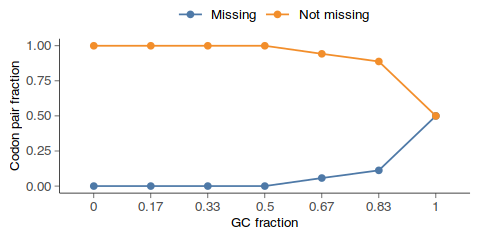

In [188]:
options(repr.plot.width=4, repr.plot.height=2)
plot_data <- insert_annotations %>% 
  bind_cols(letterFrequency(DNAStringSet(.$dicodon), as.prob=T, letter=c("G", "C"))) %>%
  mutate(gc = as.factor(round(G+C, 2))) %>%
  select(-G, -C) %>%
  mutate(missing = if_else(insert_num %in% missing_dicodons_linkage, "Missing", "Not missing")) %>% 
  group_by(gc, missing) %>%
  summarise(n = n(), .groups = "drop") %>%
  complete(missing, gc, fill = list(n = 0)) %>% 
  group_by(gc) %>% 
  mutate(perc = n/sum(n)) %>%
  ungroup()

plot_data %>% 
  ggplot(aes(x = gc, y = perc, color = missing, group = missing)) +
  geom_line() +
  geom_point() +
  theme +
  theme(legend.box.margin=margin(-12,-12,-12,-12),
        legend.position='top') +
  ggthemes::scale_color_tableau() +
  labs(x = "GC fraction", y = "Codon pair fraction", color = "")

ggsave("../figures/missing_in_linkage_by_gc_content.pdf", width=2.5, height=1.7)

In [189]:
if (file.exists('../tables')){
    insert_annotations %>%
        filter(insert_num %in% missing_dicodons_linkage) %>%
        write_csv("../tables/missing_dicodons_plasmid_library.csv")
} else {
    dir.create('../tables')
    insert_annotations %>%
        filter(insert_num %in% missing_dicodons_linkage) %>%
        write_csv("../tables/missing_dicodons_plasmid_library.csv")
}

### Plot dipeptides missing in barcodeseq
- Excluding those missing in plasmid library

In [190]:
sample_annotations = read_csv("../annotations/sample_annotations.csv", comment='#')
sample_annotations

Rows: 2 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): owner, sample_type, sample_name, plasmid, library_type, illumina_s...
dbl  (3): barcode_read, barcode_start, barcode_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


owner,sample_type,sample_name,plasmid,library_type,illumina_sample_id,sample_id,barcode_read,barcode_start,barcode_length,linkage_ref,r1_file,r2_file,s3,shared
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
kc,dicodon_yeast,wt_gdna,pHPSC1142,grna,51lib2,51lib2,1,1,24,yeast_cyto_linkage,kc_51lib2_S13_R1_001,kc_51lib2_S13_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/
kc,dicodon_yeast,wt_mrna,pHPSC1142,mrna,51lib1,51lib1,1,1,24,yeast_cyto_linkage,kc_51lib1_S12_R1_001,kc_51lib1_S12_R2_001,fh-pi-subramaniam-a-eco/data/kchen/illumina/20220328_exp51_wt_8xdicodon/,/shared/ngs/illumina/subramaniam_lab/220328_VH00319_178_AAAYF3FM5/Unaligned/Project_subramaniam_lab/


In [191]:
barcode_counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 197785 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 172594 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [192]:
barcode_insert_counts <- barcode_counts %>% 
  left_join(select(sample_annotations, c(sample_id, sample_name)), by = "sample_name") %>%
  left_join(insert_barcode_linkages, by = c("barcode_num", "barcode", "insert_num", "linkage_count")) %>%
  drop_na(barcode_count) %>%
  select(-sample_id)

head(barcode_insert_counts)

barcode_count,insert_num,barcode_num,barcode,linkage_count,sample_name,linkage_ref
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
4871,186,1643847,AGTCGTTGTAGCAACTCGATGTTT,16,wt_gdna,yeast_cyto_linkage
4653,5658,1596380,CTGGATGTCGCGAGCAACAACAGC,17,wt_gdna,yeast_cyto_linkage
3823,5810,764917,TGTATTCGGGCCAGCATGAGGTGC,4,wt_gdna,yeast_cyto_linkage
3656,2787,1040412,AGCGATTAGAGCATTTCTGGCCAC,3,wt_gdna,yeast_cyto_linkage
3577,203,1644177,TGGGATCTTTTCGCGTATTCGGTT,16,wt_gdna,yeast_cyto_linkage
3497,4868,692986,TCGCTCCGTGTCGTGTCTCCTATG,4,wt_gdna,yeast_cyto_linkage


In [193]:
wt_dicodon_nocutoffs <- barcode_counts %>%
    mutate(sample_type = str_extract(sample_name, '[^_]+$')) %>%
    mutate(sample_name = str_extract(sample_name, '[^_]+')) %>%
    filter(sample_name == 'wt') %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-barcode, -aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(barcode_count)) %>%
    drop_na()

In [194]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}

wt_bootstrap_dicodon_nocutoffs <- wt_dicodon_nocutoffs %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  inner_join(insert_annotations, by = "dicodon") %>%
  mutate(strain = 'wt')

In [195]:
sequenced_inserts <- wt_bootstrap_dicodon_nocutoffs %>%
    dplyr::pull(insert_num)

In [196]:
missing_dicodons <- setdiff(seq(0,4095), sequenced_inserts)
missing_barcodeseq <- setdiff(missing_dicodons, missing_dicodons_linkage)

In [199]:
dicodons_missing_aa1 <- insert_annotations %>%
    filter(insert_num %in% missing_barcodeseq) %>%
    group_by(diaa) %>%
    summarize(n_missing_dicodons = n(), .groups='drop') %>%
    mutate(aa1 = str_sub(diaa, 1,1)) %>%
    mutate(aa2 = str_sub(diaa, 2,2)) %>%
    filter(aa1 != aa2) %>%
    group_by(aa1) %>%
    summarize(sum_missing_dicodons = sum(n_missing_dicodons)) %>%
    dplyr::rename(aa = aa1)

dicodons_missing_aa2 <- insert_annotations %>%
    filter(insert_num %in% missing_barcodeseq) %>%
    group_by(diaa) %>%
    summarize(n_missing_dicodons = n(), .groups='drop') %>%
    mutate(aa1 = str_sub(diaa, 1,1)) %>%
    mutate(aa2 = str_sub(diaa, 2,2)) %>%
    filter(aa1 != aa2) %>%
    group_by(aa2) %>%
    summarize(sum_missing_dicodons = sum(n_missing_dicodons)) %>%
    dplyr::rename(aa = aa2)

dicodons_missing_both <- insert_annotations %>%
    filter(insert_num %in% missing_barcodeseq) %>%
    group_by(diaa) %>%
    summarize(n_missing_dicodons = n(), .groups='drop') %>%
    mutate(aa1 = str_sub(diaa, 1,1)) %>%
    mutate(aa2 = str_sub(diaa, 2,2)) %>%
    filter(aa1 == aa2) %>%
    group_by(aa1) %>%
    summarize(sum_missing_dicodons = sum(n_missing_dicodons)) %>%
    dplyr::rename(aa = aa1)

In [200]:
total_missing_aa <- bind_rows(dicodons_missing_both, dicodons_missing_aa1, dicodons_missing_aa2) %>%
    group_by(aa) %>%
    summarize(total_dicodons_missing_this_aa = sum(sum_missing_dicodons), .groups='drop')

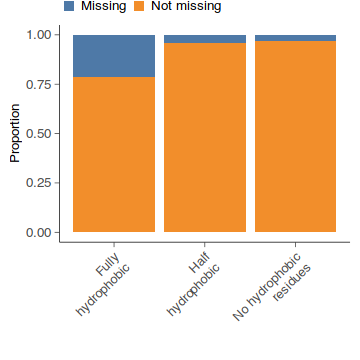

In [203]:
options(repr.plot.width = 3, repr.plot.height = 3)

insert_annotations %>%
    mutate(type = case_when((aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Fully\nhydrophobic',
                            (aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & !(aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            !(aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            TRUE ~ 'No hydrophobic\nresidues')) %>%
    mutate(missing = ifelse(insert_num %in% missing_barcodeseq, 'Missing', 'Not missing')) %>%
    group_by(type, missing) %>%
    summarize(total = n(), .groups='drop') %>%
    group_by(type) %>%
    mutate(proportion = total / sum(total)) %>%
    ggplot() +
    aes(x=type, y=proportion, fill=missing) +
    geom_bar(stat='identity') +
    ggthemes::scale_fill_tableau() +
    theme +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1),
        legend.position = "top",
        legend.justification='left',
        legend.box.margin=margin(-12,-12,-12,-12),
        legend.key.height = unit(0.25, 'cm'),
        legend.key.width = unit(0.25, 'cm'),) +
    labs(x='', y='Proportion', fill='')

ggsave("../figures/proportion_missing_hydrophobic_barcodeseq.pdf", width=1.8, height=2.2)

## Plot missing data in Hel2-del and Syh1-del strains

- If we define missing as the dicodon's lfc is missing (grey square on the heat map)
  - this doesn't necessarily mean that the dicodon never got sequenced, but could also mean that barcodes never matched up between gDNA and cDNA libraries.
- The below is how the the dicodon heatmap in fig2 is generated

In [206]:
counts <- list.files("../../hel2_syh1_mrna_grna/data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 99948 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 163535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 110997 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the colu

In [207]:
barcode_counts <- counts %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    mutate(sample_type = ifelse(str_detect(sample_type, 'reseq'), str_extract(sample_name, '(?<=_).+(?=_)'), sample_type)) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count) %>%
    group_by(genotype, sample_type, barcode_num, insert_num) %>% # combine resequenced counts together
    summarize(barcode_count = sum(barcode_count), .groups='drop')

In [208]:
wt_barcode_counts <- read_tsv("../tables/barcode_insert_counts.tsv.gz") %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count)

Rows: 370377 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): barcode, sample_name, linkage_ref
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [209]:
all_barcode_counts <- bind_rows(barcode_counts, wt_barcode_counts)

In [210]:
wt_dicodon_nocutoffs <- all_barcode_counts %>%
    filter(genotype == 'wt') %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(barcode_count)) %>%
    drop_na()

hel2_dicodon_nocutoffs <- all_barcode_counts %>%
    filter(genotype == 'hel2') %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(barcode_count)) %>%
    drop_na()

syh1_dicodon_nocutoffs <- all_barcode_counts %>%
    filter(genotype == 'syh1') %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(barcode_count)) %>%
    drop_na()

In [211]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$gdna))
}

wt_bootstrap_dicodon_nocutoffs <- wt_dicodon_nocutoffs %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  inner_join(insert_annotations, by = "dicodon") %>%
  mutate(genotype = 'WT')

hel2_bootstrap_dicodon_nocutoffs <- hel2_dicodon_nocutoffs %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  inner_join(insert_annotations, by = "dicodon") %>%
  mutate(genotype = 'Hel2-del')

syh1_bootstrap_dicodon_nocutoffs <- syh1_dicodon_nocutoffs %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  inner_join(insert_annotations, by = "dicodon") %>%
  mutate(genotype = 'Syh1-del')

dicodon_bootstrap_nocutoffs <- bind_rows(wt_bootstrap_dicodon_nocutoffs, hel2_bootstrap_dicodon_nocutoffs, syh1_bootstrap_dicodon_nocutoffs)

In [212]:
wt_inserts <- dicodon_bootstrap_nocutoffs %>%
    filter(genotype == 'WT') %>%
    dplyr::pull(insert_num)

hel2_inserts <- dicodon_bootstrap_nocutoffs %>%
    filter(genotype == 'Hel2-del') %>%
    dplyr::pull(insert_num)

syh1_inserts <- dicodon_bootstrap_nocutoffs %>%
    filter(genotype == 'Syh1-del') %>%
    dplyr::pull(insert_num)

all_inserts <- seq(0, 4095)

In [266]:
wt_missing <- setdiff(all_inserts, wt_inserts)
hel2_missing <- setdiff(all_inserts, hel2_inserts)
syh1_missing <- setdiff(all_inserts, syh1_inserts)
wt_hel2_both <- intersect(wt_missing, hel2_missing)
missing_all <- intersect(syh1_missing, wt_hel2_both)
missing_all_yeast <- setdiff(missing_all, missing_dicodons_linkage) 

In [267]:
wt_missing_df <- insert_annotations %>%
    filter(insert_num %in% wt_missing) %>%
    filter(!(insert_num %in% missing_dicodons_linkage)) %>%
    mutate(genotype = 'WT')

hel2_missing_df <- insert_annotations %>%
    filter(insert_num %in% hel2_missing) %>%
    filter(!(insert_num %in% missing_dicodons_linkage)) %>%
    mutate(genotype = 'Hel2-del')

syh1_missing_df <- insert_annotations %>%
    filter(insert_num %in% syh1_missing) %>%
    filter(!(insert_num %in% missing_dicodons_linkage)) %>%
    mutate(genotype = 'Syh1-del')

missing_df <- bind_rows(wt_missing_df, hel2_missing_df, syh1_missing_df)

In [268]:
length(missing_all_yeast)/nrow(wt_missing_df)
length(missing_all_yeast)/nrow(hel2_missing_df)
length(missing_all_yeast)/nrow(syh1_missing_df)
length(missing_all_yeast)

[1] 0.5720165

[1] 0.4357367

[1] 0.4412698

[1] 139

In [252]:
missing_df %>%
    mutate(type = case_when((aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Fully\nhydrophobic',
                            (aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & !(aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            !(aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            TRUE ~ 'No hydrophobic\nresidues')) %>%
    filter(insert_num %in% missing_all) %>%
    group_by(dicodon) %>%
    dplyr::slice(1) %>%
    select(-genotype) %>%
    ungroup() %>%
    group_by(type) %>%
    summarize(proportion_of_missing = n()/139)

type,proportion_of_missing
<chr>,<dbl>
Fully hydrophobic,0.4100719
Half hydrophobic,0.3093525
No hydrophobic residues,0.2805755


In [274]:
missing_types <- insert_annotations %>%
    filter(insert_num %in% missing_all_yeast) %>%
    mutate(type = case_when((aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Fully\nhydrophobic',
                            (aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & !(aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            !(aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            TRUE ~ 'No hydrophobic\nresidues')) %>%
    group_by(type) %>%
    summarize(n_dicodons_missing = n())

In [275]:
totals <- insert_annotations %>%
    mutate(type = case_when((aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Fully\nhydrophobic',
                            (aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & !(aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            !(aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            TRUE ~ 'No hydrophobic\nresidues')) %>%
    group_by(type) %>%
    summarize(n_dicodons_total = n())

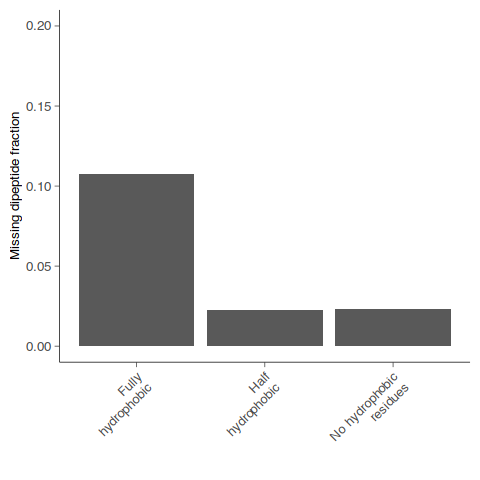

In [276]:
missing_types %>%
    inner_join(totals, by='type') %>%
    mutate(percent_dicodons = (n_dicodons_missing / n_dicodons_total)) %>%
    ggplot() +
    aes(x=type, y=percent_dicodons) %>%
    geom_bar(stat='identity') +
    scale_y_continuous(limits=c(0, 0.20)) +
    theme + 
    theme(
        axis.line = element_blank(),
        axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
    ) +
    labs(x='', y='Missing dipeptide fraction')

ggsave("../figures/percent_inserts_missing_hydrophobic_all_strains.pdf", width=1.8, height=2)

In [277]:
insert_annotations %>%
    filter(insert_num %in% missing_all_yeast) %>%
    mutate(type = case_when((aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Fully\nhydrophobic',
                            (aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & !(aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            !(aa1 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) & (aa2 %in% c('A', 'I', 'L', 'M', 'F', 'W', 'Y', 'V')) ~ 'Half\nhydrophobic',
                            TRUE ~ 'No hydrophobic\nresidues')) %>%
    group_by(diaa, type) %>%
    summarize(n_dicodons = n()) %>%
    group_by(type) %>%
    summarize(n_diaa = n())

`summarise()` has grouped output by 'diaa'. You can override using the
`.groups` argument.


type,n_diaa
<chr>,<int>
Fully hydrophobic,26
Half hydrophobic,32
No hydrophobic residues,29
